In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
from datasets import load_from_disk

In [3]:
sys.path.append("/mnt/storage2/arafat_shovon/flow_matching_and_llm/notebooks")

In [4]:
from transformers import(
    Blip2ForConditionalGeneration,
    Blip2Processor
)

**Load the Model**

In [5]:
model_name = "Salesforce/blip2-opt-2.7b"

processor = Blip2Processor.from_pretrained(model_name, 
                                        cache_dir="../data/cache")

model = Blip2ForConditionalGeneration.from_pretrained(model_name,
                                                    torch_dtype=torch.float16,
                                                    cache_dir="../data/cache",
                                                    attn_implementation="eager",
                                                    device_map="auto")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**Load the Dataset**

In [6]:
data = load_from_disk("../data/flickr8k/train")

**GradCam Class**

In [ ]:
class BLIP2GradECLIP:
    """
    Grad-eCLIP for BLIP2 Image Captioning - Memory Efficient (Half Precision)
    """
    
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.device = next(model.parameters()).device
        self.dtype = torch.float16
        
        self.num_heads = model.vision_model.config.num_attention_heads
        self.hidden_size = model.vision_model.config.hidden_size
        self.head_dim = self.hidden_size // self.num_heads
        
        self.q = None
        self.k = None
        self.v = None
        self.attn_output = None
        
        self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks to capture Q, K, V and attention output."""
        last_layer = self.model.vision_model.encoder.layers[-1]
        self_attn = last_layer.self_attn
        
        def qkv_hook(module, input, output):
            B, N, _ = output.shape
            qkv = output.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
            
            self.q = qkv[0].detach().half()
            self.k = qkv[1].detach().half()
            self.v = qkv[2].detach().half()
        
        def attn_output_hook(module, input, output):
            if isinstance(output, tuple):
                self.attn_output = output[0]
            else:
                self.attn_output = output
        
        self.qkv_handle = self_attn.qkv.register_forward_hook(qkv_hook)
        self.attn_handle = last_layer.self_attn.register_forward_hook(attn_output_hook)
    
    def remove_hooks(self):
        self.qkv_handle.remove()
        self.attn_handle.remove()
    
    @torch.cuda.amp.autocast(dtype=torch.float16)
    def generate_gradcam(self, image):
        """Generate Grad-eCLIP attention map in half precision."""
        orig_size = image.size
        
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        pixel_values = inputs['pixel_values'].half()
        
        self.model.eval()
        
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            generated_ids = self.model.generate(
                pixel_values=pixel_values,
                max_new_tokens=30  # Reduced for memory
            )
        caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
        
        # Clear cache after generation
        torch.cuda.empty_cache()
        
        # Reset captured values
        self.q = None
        self.k = None
        self.v = None
        self.attn_output = None
        
        # Get feature map size
        img_size = pixel_values.shape[-1]
        patch_size = self.model.vision_model.config.patch_size
        feat_h = feat_w = img_size // patch_size
        
        # Step 2: Forward pass with gradients
        outputs = self.model(
            pixel_values=pixel_values,
            labels=generated_ids,
            input_ids=generated_ids,
            return_dict=True
        )
        
        score = outputs.loss
        
        # Step 3: Compute gradient
        if self.attn_output is None:
            raise ValueError("Attention output not captured!")
        
        grad = torch.autograd.grad(
            score,
            self.attn_output,
            retain_graph=False  # Don't retain to save memory
        )[0]
        grad = grad.detach().half()
        
        # Clear cache
        torch.cuda.empty_cache()
        
        print(f"Gradient shape: {grad.shape}")
        print(f"Q: {self.q.shape}, K: {self.k.shape}, V: {self.v.shape}")
        print(f"Feature map: {feat_h}x{feat_w}")
        
        # Step 4: Compute Grad-eCLIP map
        head_idx = 0
        
        grad_cls = grad[:, :1, :]
        q_cls = self.q[:, head_idx, :1, :]
        k_patch = self.k[:, head_idx, 1:, :]
        v_patch = self.v[:, head_idx, 1:, :]
        
        # Cosine similarity
        q_cls_norm = F.normalize(q_cls, dim=-1)
        k_patch_norm = F.normalize(k_patch, dim=-1)
        cosine_qk = (q_cls_norm * k_patch_norm).sum(-1)
        cosine_qk = (cosine_qk - cosine_qk.min()) / (cosine_qk.max() - cosine_qk.min() + 1e-8)
        
        grad_cls_head = grad_cls[:, :, head_idx * self.head_dim:(head_idx + 1) * self.head_dim]
        
        # Grad-eCLIP formula
        emap = F.relu((grad_cls_head * v_patch * cosine_qk.unsqueeze(-1)).sum(-1))
        emap = emap[0].reshape(feat_h, feat_w)
        
        # Normalize
        emap = emap - emap.min()
        if emap.max() > 0:
            emap = emap / emap.max()
        
        emap = emap.detach().cpu().float().numpy()
        emap_resized = cv2.resize(emap, orig_size)
        
        # Clean up to free memory
        del grad, self.q, self.k, self.v, self.attn_output
        self.q = self.k = self.v = self.attn_output = None
        torch.cuda.empty_cache()
        
        return emap_resized, caption, emap
    
    def visualize(self, image, hmap, caption=None):
        img_np = np.array(image)
        
        hmap = hmap.copy()
        hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min() + 1e-8)
        
        if hmap.shape[:2] != img_np.shape[:2]:
            hmap = cv2.resize(hmap, (img_np.shape[1], img_np.shape[0]))
        
        heatmap = cv2.applyColorMap((hmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = np.clip(img_np * 0.5 + heatmap * 0.5, 0, 255).astype(np.uint8)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img_np)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        axes[1].imshow(hmap, cmap='jet')
        axes[1].set_title("Grad-eCLIP")
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title("Overlay")
        axes[2].axis('off')
        
        if caption:
            fig.suptitle(f"Caption: {caption}", fontsize=12, y=1.02)
        plt.tight_layout()
        plt.show()
        
        return overlay

/tmp/ipykernel_13307/340187779.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(dtype=torch.float16)


In [8]:
grad_eclip = BLIP2GradECLIP(model, processor)

Gradient shape: torch.Size([1, 257, 1408])
Q: torch.Size([1, 16, 257, 88]), K: torch.Size([1, 16, 257, 88]), V: torch.Size([1, 16, 257, 88])
Feature map: 16x16
Real Caption: A brown dog stands in a lush field with the stunning clouds and mountains behind it .
Generated Caption: a dog running through tall grass with mountains in the background



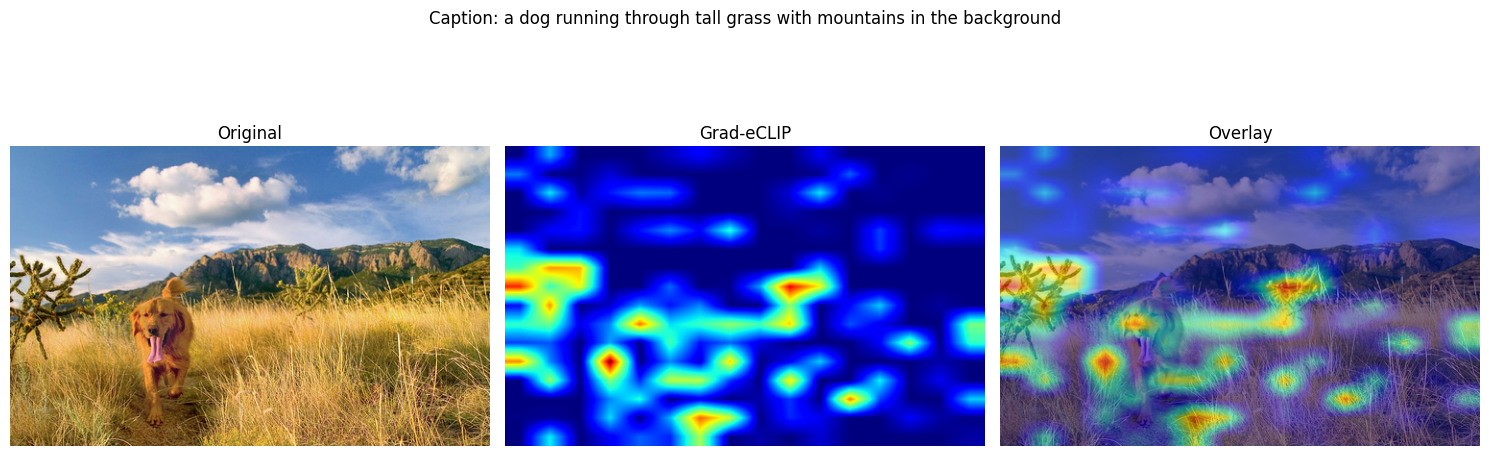

array([[[ 46,  71, 159],
        [ 47,  72, 160],
        [ 47,  73, 160],
        ...,
        [105, 106, 167],
        [106, 106, 168],
        [108, 106, 168]],

       [[ 46,  72, 159],
        [ 47,  72, 160],
        [ 47,  73, 160],
        ...,
        [105, 106, 167],
        [107, 106, 168],
        [108, 107, 168]],

       [[ 47,  73, 160],
        [ 47,  73, 160],
        [ 47,  73, 160],
        ...,
        [106, 106, 168],
        [108, 107, 168],
        [109, 107, 168]],

       ...,

       [[ 61,  52,  85],
        [ 47,  35,  69],
        [ 62,  46,  82],
        ...,
        [ 77,  56, 100],
        [ 60,  41,  89],
        [ 78,  64, 111]],

       [[ 65,  55,  90],
        [ 57,  46,  81],
        [ 52,  37,  73],
        ...,
        [ 88,  67, 115],
        [ 85,  65, 116],
        [ 62,  48,  95]],

       [[ 69,  60,  93],
        [ 50,  39,  73],
        [ 58,  43,  78],
        ...,
        [ 47,  28,  82],
        [ 64,  47, 103],
        [ 87,  75, 126]]

In [11]:
# index = np.random.randint(0, len(data))
index = 5397
image = data[index]['image']
attn_map, caption, raw_map = grad_eclip.generate_gradcam(image)
print(f"Real Caption: {data[index]['caption_0']}")
print(f"Generated Caption: {caption}")
grad_eclip.visualize(image, attn_map, caption)

In [ ]:
import os
os.makedirs("../data/heatmap/train", exist_ok=True)

In [ ]:
for i in range(len(data)):
    image = data[i]['image']
    attn_map, _, _ = grad_eclip.generate_gradcam(image)
    file_name = f"../data/heatmap/train/{i}_hetmap.npy"
    np.save(file_name, attn_map)